In [ ]:
import numpy as np
X = [4, 5, 3, 1, 2]
print(np.sort(X))

[1 2 3 4 5]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style('white')
plt.set_cmap('gist_gray')

!pip install --quiet nibabel
import nibabel as nib

! git clone https://github.com/SimJeg/BrainAge.git

Cloning into 'BrainAge'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (39/39), done.


<Figure size 432x288 with 0 Axes>

In [ ]:
df = pd.read_csv('BrainAge/demographics.csv')
df.head(10)

,id,dataset,sex,hospital,age,path_process_data
0,0,ixi,f,Guys,35.800137,IXI002/
1,1,ixi,m,HH,38.781656,IXI012/
2,2,ixi,m,HH,46.710472,IXI013/
3,3,ixi,f,HH,34.236824,IXI014/
4,4,ixi,m,HH,24.284736,IXI015/
5,5,ixi,m,Guys,55.167693,IXI016/
6,6,ixi,f,Guys,29.092402,IXI017/
7,7,ixi,m,Guys,58.658453,IXI019/
8,8,ixi,m,Guys,39.466119,IXI020/
9,9,ixi,f,Guys,21.566051,IXI021/


In [ ]:
print('There are {} patients'.format(len(df)))
print('There are {} hospitals'.format(len(df.hospital.unique())))
print('There are {} datasets'.format(len(df.dataset.unique())))
print('There are {:.2f}% of women'.format(100*np.mean(df.sex == 'f')))
print('Age statistics : ')
print(df.age.describe())

There are 1597 patients
There are 25 hospitals
There are 2 datasets
There are 55.48% of women
Age statistics : 
count    1597.000000
mean       35.599132
std        17.491271
min        18.000000
25%        22.000000
50%        27.000000
75%        48.052019
max        86.318960
Name: age, dtype: float64


Text(0.5, 1.0, 'Figure 1. Patient distribution per hospital')

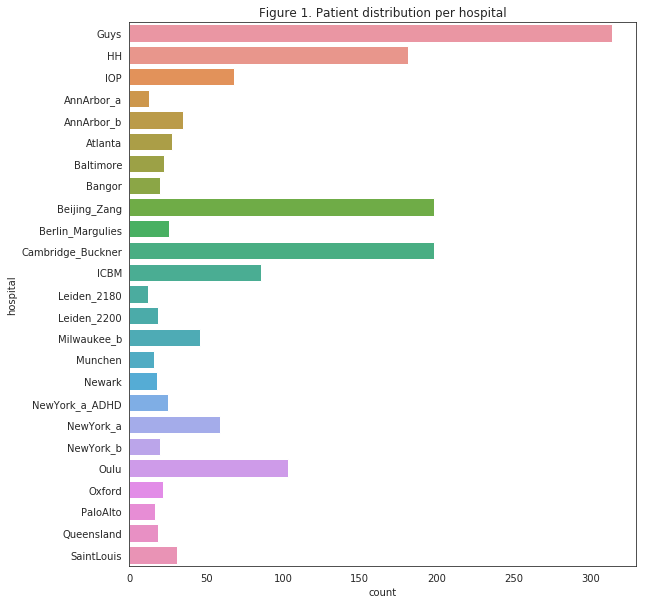

In [ ]:
plt.figure(figsize=(20,10)) 
plt.subplot(121) 
sns.countplot(y='hospital', data=df)
plt.title('Figure 1. Patient distribution per hospital')

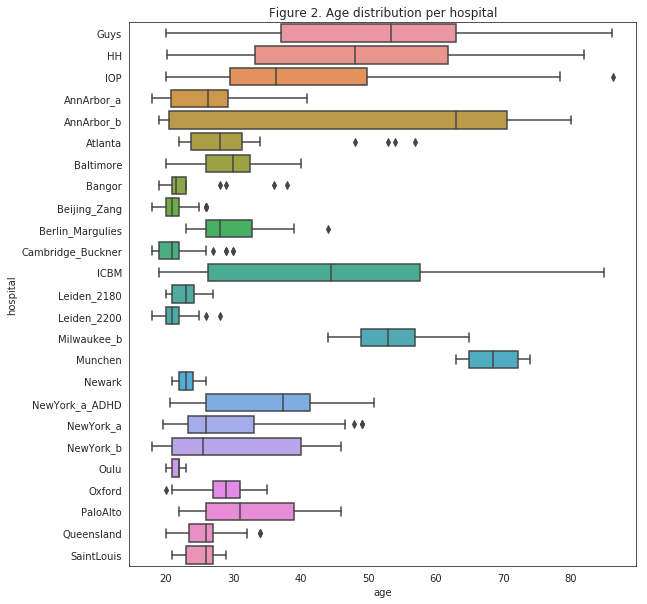

In [ ]:
plt.figure(figsize=(20,10)) 
plt.subplot(122)
sns.boxplot(x='age', y='hospital', data=df)
plt.title('Figure 2. Age distribution per hospital');

In [ ]:
image = nib.load('BrainAge/input.nii.gz').get_data()
segmentation = nib.load('BrainAge/segmentation.nii.gz').get_data()
# It allows to simply skullstrip the image : 
skullstripped_image = image * (segmentation > 0)
# Choose the dimension : 0 (sagittal), 1 (coronnal) or 2 (axial)
dimension = 2
# Choose the slice (between 0 and 182 or 218)
s = 100


Shape of the MRI : (182, 218, 182)


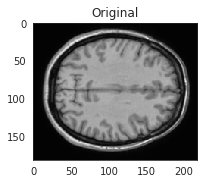

In [ ]:
plt.figure(figsize=(10, 5))
print('Shape of the MRI : {}'.format(image.shape))
plt.subplot(131)
plt.imshow(np.take(image, s, dimension))
plt.title('Original');

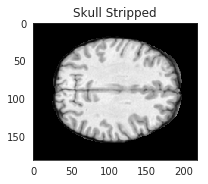

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(132)
plt.imshow(np.take(skullstripped_image, s, dimension))
plt.title('Skull Stripped');

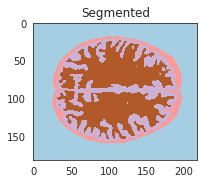

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(133)
plt.imshow(np.take(segmentation, s, dimension), cmap='Paired')
plt.title('Segmented');

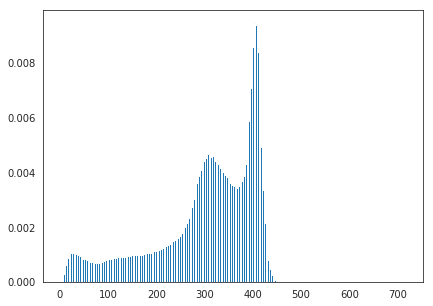

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
# We only use POSITIVE values (background removed) to compute the histogram
plt.hist(skullstripped_image[skullstripped_image > 0], bins=200, density=True); 


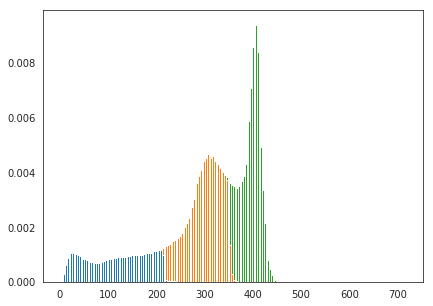

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.hist([skullstripped_image[segmentation == i] for i in [1, 2, 3]], 
         stacked=True, bins=200, density=True);


In [ ]:
# Load the histograms X for all patients and the ages Y
X = np.load('BrainAge/histograms.npy')
Y = df.age.values
print('Shape of X : {}'.format(np.shape(X)))


Shape of X : (1597, 200)


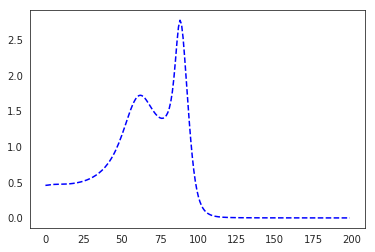

In [ ]:
 # We plot the average histogram in blue
plt.plot(X.mean(0), 'b--')

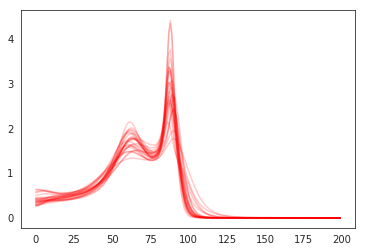

In [ ]:
# And the average histogram per hospital in red using a for loop
for h in df.hospital.unique():
  plt.plot(X[df.hospital == h].mean(0), 'r', alpha=0.2)

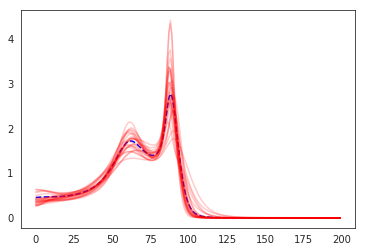

In [ ]:
# We plot the average histogram in blue
plt.plot(X.mean(0), 'b--')

# And the average histogram per hospital in red using a for loop
for h in df.hospital.unique():
  plt.plot(X[df.hospital == h].mean(0), 'r', alpha=0.2)

In [ ]:
10**np.linspace(-3.0, 2.0, 10)

array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])

Random Split
Size of the test set : 320 patients


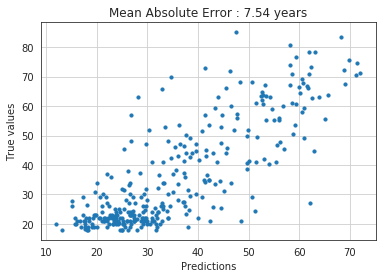

Hospital Split
Size of the test set : 314 patients


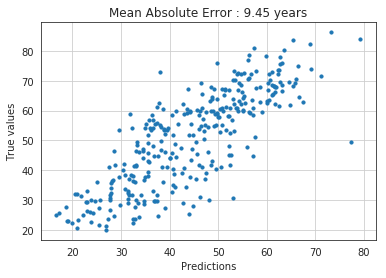

In [ ]:
# Scikit Learn is the most popular package for machine learning in python
# We use it to train a linear model with L2 regularization (Ridge Regression)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
n_patients = len(df)

# We create a function to train and test a linear model

def train_linear_regression(train, test):
    # Create model
    model = RidgeCV()

    # Train on the training set : fit the models with pairs (X, Y)
    model.fit(X[train], Y[train])

    # Predict on the test set
    predictions = model.predict(X[test])
    true_values = Y[test]
    
    # Plot the results and compute the MAE
    plt.scatter(predictions, true_values, s=10)
    plt.grid()
    plt.xlabel('Predictions')
    plt.ylabel('True values')
    mae = np.mean(np.abs(predictions - true_values))
    plt.title('Mean Absolute Error : {:.2f} years'.format(mae))
    plt.show()


# We don't perform 5 fold cross validation here, but a single split

# 1. Random split
# We randomly split the data between train and test with 80/20 proportions
train, test = train_test_split(np.arange(n_patients), test_size=0.2,
                               random_state=0)
print('Random Split')
print('Size of the test set : {} patients'.format(len(test)))
# We use our function on this split
train_linear_regression(train, test)


Hospital Split
Size of the test set : 314 patients


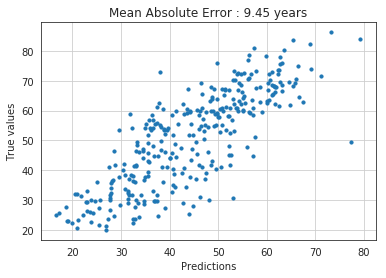

In [ ]:
# 2. Hospital split
# We split the hospitals using Guys hospital as the test set
train = np.where(df.hospital != 'Guys')[0]
test = np.where(df.hospital == 'Guys')[0]
print('Hospital Split')
print('Size of the test set : {} patients'.format(len(test)))
train_linear_regression(train, test)

In [ ]:
# We will use the keras package for deep learning models
from keras.models import load_model


Using TensorFlow backend.


In [ ]:
model = load_model('BrainAge/cnn_model.h5')

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 198, 198, 32)      320       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 196, 196, 32)      9248      
_________________________________________________________________
batch_normalization_41 (Batc (None, 196, 196, 32)      128       
_________________________________________________________________
average_pooling2d_41 (Averag (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 94, 94, 64)        36928     
__________

In [ ]:
# Get predictions : we first need to prepare the input image
    
X = skullstripped_image

# Step 1 : Normalize Intensities
h, t = np.histogram(X[segmentation == 3], bins=100)
peak_wm = t[np.argmax(h)]
h, t = np.histogram(X[segmentation == 2], bins=100)
peak_gm = t[np.argmax(h)]

X /= peak_wm
C = peak_gm / peak_wm
a = (0.75 - C**2) / (C - C**2)
X[X < 1] = a * X[X < 1] + (1 - a) * X[X < 1]**2
X = np.clip(X, 0, 1.5) / 1.5

# Step 2 : resize the image to get (200, 200) shape

X = X[:, 10:-8, 80:90]
X = np.pad(X, ((9,9), (0,0), (0,0)), mode='constant')
X = np.rollaxis(X, 2, 0)[..., None]

# Step 3 : use the trained model to make the predictions

predictions = 10 * model.predict(X)[:, 0]

In [ ]:
real_age = df.age[0]
print('Real age : {:.2f} years'.format(real_age))


Real age : 35.80 years


In [ ]:
print('Number of predictions : {}'.format(len(predictions)))


Number of predictions : 10


In [ ]:
print('Average prediction : {:.2f} years'.format(np.mean(predictions)))

Average prediction : 30.66 years


In [ ]:
print('Minimal prediction : {:.2f} years '.format(np.min(predictions)))

Minimal prediction : 26.20 years 


In [ ]:
print('Maximal prediction : {:.2f} years '.format(np.max(predictions)))

Maximal prediction : 34.31 years 
